# Идентификация пользователей по посещенным веб-страницам

## Постановка задачи

Перед нами стоит задача идентификации пользователя по его поведению в сети Интернет.

Будем решать задачу идентификации взломщика по его поведению в сети Интернет. 
Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. 
В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. 
В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. 

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

import itertools

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import time
from datetime import datetime

In [2]:
PATH_TO_DATA = 'data'

train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


## Визуальный анализ признаков

Создадим несколько признаков и попробуем их визуализировать.

In [3]:
def features(df):
    df = df.copy()
    
    times = ['time%s' % i for i in range(1,11)]
    sites = ['site%s' % i for i in range(1,11)]
    
    for col in times:
        df[col] = pd.to_datetime(df[col],format='%Y-%m-%d %H:%M:%S')
    
    df['start_hour'] = df['time1'].apply(lambda x: x.hour)
    df['end_hour'] = df['time10'].apply(lambda x: x.hour)
    df['day'] = df['time1'].apply(lambda x: x.dayofweek)
    df['session_length'] = (df['time10'] - df['time1']).apply(lambda x: x.seconds)
    df['sites_in_session'] = df[sites].count(axis=1)
    
    df[sites] = df[sites].fillna(0).astype(int)
    df['unique_sites_in_session'] = [np.nonzero(np.unique(x))[0].size for x in df[sites].values]

    
    # sites per second
    df['sites_per_second'] = df['sites_in_session'] / df['session_length'].replace(0, 1)
    
    
    df.reset_index(drop=True, inplace=True)
    
    return df

df = features(train_df)
df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site10,time10,target,start_hour,end_hour,day,session_length,sites_in_session,unique_sites_in_session,sites_per_second
0,718,2014-02-20 10:02:45,0,NaT,0,NaT,0,NaT,0,NaT,...,0,NaT,0,10,NaN,3,NaN,1,1,NaN
1,890,2014-02-22 11:19:50,941,2014-02-22 11:19:50,3847,2014-02-22 11:19:51,941,2014-02-22 11:19:51,942,2014-02-22 11:19:51,...,1518,2014-02-22 11:20:16,0,11,11.0,5,26.0,10,7,0.384615
2,14769,2013-12-16 16:40:17,39,2013-12-16 16:40:18,14768,2013-12-16 16:40:19,14769,2013-12-16 16:40:19,37,2013-12-16 16:40:19,...,14768,2013-12-16 16:40:24,0,16,16.0,0,7.0,10,4,1.428571
3,782,2014-03-28 10:52:12,782,2014-03-28 10:52:42,782,2014-03-28 10:53:12,782,2014-03-28 10:53:42,782,2014-03-28 10:54:12,...,782,2014-03-28 10:56:42,0,10,10.0,4,270.0,10,1,0.037037
4,22,2014-02-28 10:53:05,177,2014-02-28 10:55:22,175,2014-02-28 10:55:22,178,2014-02-28 10:55:23,177,2014-02-28 10:55:23,...,178,2014-02-28 10:57:11,0,10,10.0,4,246.0,10,4,0.040650


Для отдельно взятого пользователя выведем гистограммы по всем фичам, и посмотрим насколько они соответствуют соотвествтующим гистограммам по всем пользователям.

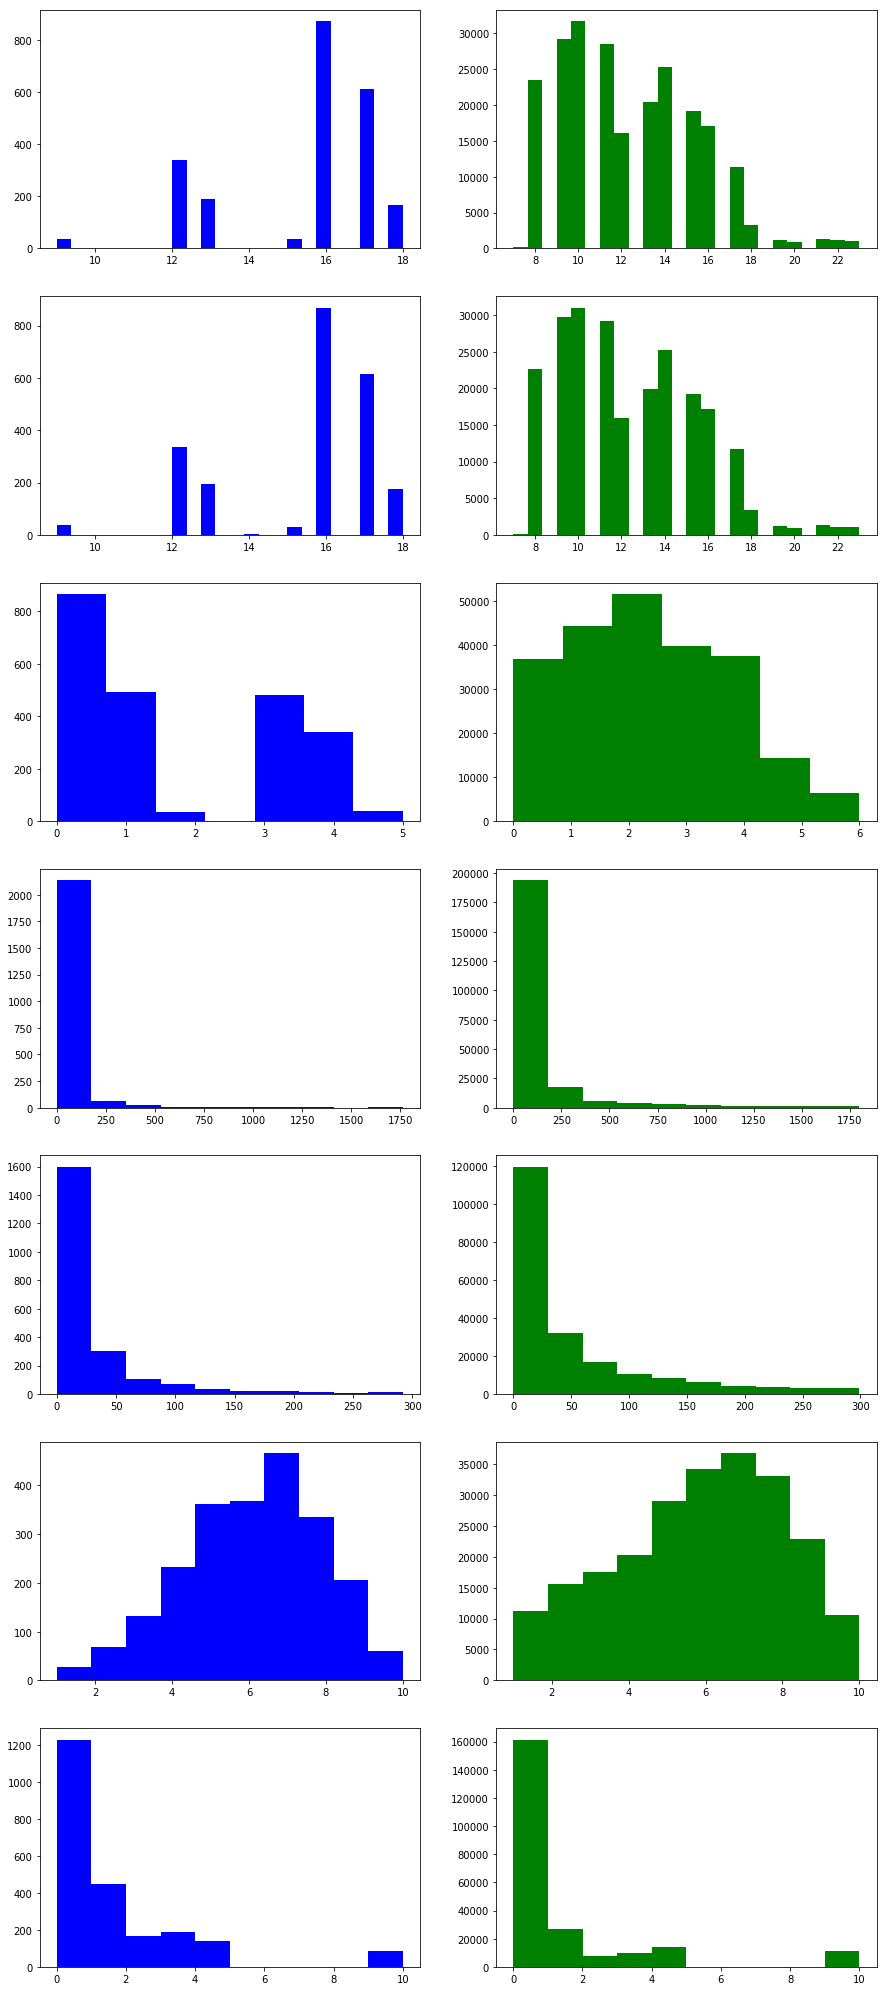

In [4]:
df = df.dropna()
us = df[df['target'] == 1]

fig, ax = plt.subplots(7, 2, figsize=(15, 36))

ax[0, 0].hist(us['start_hour'], bins=24, color='blue')
ax[0, 1].hist(df['start_hour'], bins=24, color='green')

ax[1, 0].hist(us['end_hour'], bins=24, color='blue')
ax[1, 1].hist(df['end_hour'], bins=24, color='green')

ax[2, 0].hist(us['day'], bins=7, color='blue')
ax[2, 1].hist(df['day'], bins=7, color='green')

ax[3, 0].hist(us['session_length'], color='blue')
ax[3, 1].hist(df['session_length'], color='green')

ax[4, 0].hist(us['session_length'][us['session_length'] < 300], color='blue')
ax[4, 1].hist(df['session_length'][df['session_length'] < 300], color='green')

ax[5, 0].hist(us['unique_sites_in_session'], color='blue')
ax[5, 1].hist(df['unique_sites_in_session'], color='green')

ax[6, 0].hist(us['sites_per_second'], color='blue')
ax[6, 1].hist(df['sites_per_second'], color='green')

pass

Заметно, что выбранный нами пользователь резко отличается от общей массы по начальному и конечному часу сессии, а так же своим распределением по дням недели. Видно, что по средам пользователь вообще не выходит в интернет.

По длине сессии и кол-ву уникальных сайтов в ней пользователь от общей массы не отличается.

По скорости посещения сессий данный пользователь также не выделяется от общей массы. Видно, что у всех пользователей есть сессии, в которых скорость посещения сайтов была довольно большой. Можно отчетливо выделить сессии со скоростью 5 и 10. Это можно объяснить тем, что разрешение по времени - одна секунда, и в то время как человек вряд ли способен просматривать более 1-2 сайтов в секунду, редиректы / реклама / трекеры будут посылать запросы намного быстрее.

## Bag-of-words для сессий

Одним из наиболее интересных способов классификации сессий является на мой взгляд применение метода bag-of-words к ним. Он довольно прост в реализации и является универсальным в том смысле что он объединяет в себе многие другие возможные фичи связанные с сайтами, такие как "популярные сайты", "любимые сайты пользователя", "домены" и т.п. 

Представим совокупность сайтов в сессии единой строкой, где сайты записаны через пробел. После этого мы можем применить к набору сессий TfIdfVectorizer / CountVectorizer из sklearn, который преобразует строки в разреженные матрицы word-фичей.

Меняя tokenizer/token_pattern у векторайзера, мы можем извлекать различные интересующие нас компоненты адресов. К примеру, для того чтобы извлечь домены, можно воспользоваться следующим выражением для token_pattern: `r'\.(\w+)(?:\s|$)'` (точка, затем 1 или более обычных символов (их захватываем), затем пробел или конец строки):

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

c = CountVectorizer(token_pattern=r'\.(\w+)(?:\s|$)')
c.fit_transform([
    'ad.google.com facebook.com something.yandex.ru r3--131312434-4-2.google.com something.gov.es'
])
c.get_feature_names()

[u'com', u'es', u'ru']

Вооружившись этими знаниями, реализуем функции для загрузки данных и подготовки фичей:

In [6]:
time_cols = ['time%s' % i for i in range(1,11)]
site_cols = ['site%s' % i for i in range(1,11)]

def make_features(df, site_dict, site_vectorizer, duration_scaler, test_set=False):
    # scaled session duration
    times_values = df[time_cols].values
    sess_duration = (duration_scaler.fit_transform if not test_set else duration_scaler.transform)(
        (times_values.max(axis=1) - times_values.min(axis=1))
            .astype('timedelta64[ms]')
            .astype(int)
            .reshape(-1, 1)
    )
    # scaled month
    month = df['time1'].apply(lambda t: t.month).values.reshape(-1, 1)
    # scaled day of week
    day_of_week = df['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    # hour
    hour = df['time1'].apply(lambda ts: ts.hour)
    # is it morning?
    morning = ((hour >= 6) & (hour < 12)).astype('int').values.reshape(-1, 1)
    # is it day?
    day = ((hour >= 12) & (hour < 18)).astype('int').values.reshape(-1, 1)
    # is it evening?
    evening = ((hour >= 18) & (hour < 24)).astype('int').values.reshape(-1, 1)
    # is it night?
    night = ((hour >= 0) & (hour < 6)).astype('int').values.reshape(-1, 1)
    # scaled hour
    hour = hour.values.reshape(-1, 1) / 23
    
    # Sessions as a single strings. Needed for representing sites as a bag of features
    sessions = df[site_cols]\
        .fillna(0)\
        .astype('int')\
        .apply(lambda row: ' '.join([site_dict[site_id] for site_id in row]), axis=1)\
        .tolist()
    
    if not test_set:
        site_features = site_vectorizer.fit_transform(sessions)
    else:
        site_features = site_vectorizer.transform(sessions)
    
    return hstack([
        site_features,
        sess_duration, 
        month,
        day_of_week,
        hour,
        morning,
        day,
        evening,
        night,
    ])

def load_data(train_path, test_path, site_dict_path):
    train_df = pd.read_csv(train_path, index_col='session_id', parse_dates=time_cols)
    test_df = pd.read_csv(test_path, index_col='session_id', parse_dates=time_cols)
    
    with open(site_dict_path, 'rb') as f:
        site_dict = dict([(v, k) for k, v in pickle.load(f).items()])
        site_dict[0] = 'N/A'
    
    scaler = StandardScaler()
    vectorizer = TfidfVectorizer()
    
    X_train = make_features(train_df, site_dict, vectorizer, scaler)
    X_test = make_features(test_df, site_dict, vectorizer, scaler, test_set=True)
    y_train = train_df['target'].astype('int').values
    
    return X_train, y_train, X_test

In [7]:
X_train, y_train, X_test = load_data(
    os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
    os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
    os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
)

## Обучение и оценка модели

Для обучения и оценки модели будем пользоваться функцией train_and_predict, определенной ниже. В качестве метрики будем использовать площадь под кривой, усредненную по всем проходам кросс-валидации.

Для кросс-валидации будем использовать TimeSeriesSplit из sklearn -- она разделяет датасет на временные интервалы фиксированного размера, что хорошо подходит для нашей задачи.

In [8]:
def train_and_predict(model, X_train, y_train, X_test, cv):
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    print(model)
    print('cv scores mean: {}'.format(cv_scores.mean()))
    
    model.fit(X_train, y_train)

    return model.predict_proba(X_test)[:, 1]

Испытаем две модели: логистическую регрессию и SGD классификатор.

In [9]:
logit = LogisticRegression(solver='lbfgs', n_jobs=-1, max_iter=1000)
sgd = SGDClassifier(loss='log', n_jobs=-1, max_iter=1000)

In [10]:
%%time
result_logit = train_and_predict(logit, X_train, y_train, X_test, cv=TimeSeriesSplit(n_splits=10))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=-1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
cv scores mean: 0.959120406331
CPU times: user 570 ms, sys: 663 ms, total: 1.23 s
Wall time: 1min 38s


In [11]:
%%time
result_sgd = train_and_predict(sgd, X_train, y_train, X_test, cv=TimeSeriesSplit(n_splits=10))

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
cv scores mean: 0.925442881604
CPU times: user 1min 33s, sys: 1.04 s, total: 1min 34s
Wall time: 6min 27s


Лучше себя показала логистическая регрессия. Отправим результаты этой модели на Kaggle!

In [12]:
def write_to_submission_file(predicted_labels, out_file, target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(
        predicted_labels, index=np.arange(1, predicted_labels.shape[0] + 1), columns=[target]
    )
    predicted_df.to_csv(out_file, index_label=index_label)

write_to_submission_file(result_logit, 'submission.csv')

## Результаты

На публичной kaggle-борде получилось 0.93+.

Использовал подход bag-of-words относительно посещенных за сессию сайтов, также включил несколько time-related фичей. Вдохновлялся вот этим кернелем https://inclass.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme: 

## Заключение

Модель работает, работает не идеально но лучше чем константа. Подходит для идентификации конкретных пользователей, а так же для определения является ли тот или иной пользователь самим собой или ботом/взломщиком (при условии того, что модель натренирована на соответствующих данных)

Дополнительно можно попытаться проверить другие алгоритмы классификации (например тот же XGBoost). Так же можно попробовать различные способы токенизации сайтов (описано выше).